# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import torch
torch.set_float32_matmul_precision('high')
from train import *

device = torch.device('cuda:1') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
# samples
batch_size = 38 # number of samples in each batch
sample_len = 300 # length of each sample
sample_model = 'Realdt' # GBM, Heston, OU, RealData, Realdt, spx_rates
lead_lag = True # whether to use lead lag transformation
lags = [1] # number of lags to use for lead lag transformation: int or list[int]
seed = 42

# real data parameters
stride = 50 # for real data
start_date = '1995-01-01' # start date for real data
end_date = '2018-09-18' # end date for real data

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8662 entries, 1995-01-01 to 2018-09-18
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   spx     8662 non-null   float64
dtypes: float64(1)
memory usage: 135.3 KB


<Axes: xlabel='Date'>

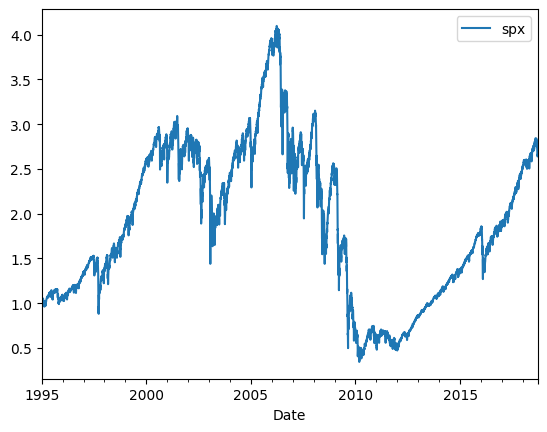

In [4]:
from pdv import PDV4

# start_date = '2011-01-01'
# end_date = '2023-01-01'

t = pd.date_range(start=start_date, end=end_date,freq = 'D')
n_timestep = len(t)
df = pd.DataFrame({'Date': t, 'spx': t})
df.set_index('Date', inplace=True)
dt = 1/365

model = PDV4()
prices, log_return, sigma, r10, r11, r20, r21, r1, r2 = model.simulate(1,n_timestep-1)
path = prices[0,:,0].astype(np.float64)
df['spx'] = path
df.to_csv('data/pdv.csv')
# df.to_csv('data/spx.csv')

# df = pd.read_csv('data/spx.csv', index_col=0, parse_dates=True)
# df.info()
df = pd.read_csv('data/pdv.csv', index_col=0, parse_dates=True)
df.info()
df.plot()

In [5]:
# signature kernel
static_kernel_type = 'rq' # type of static kernel to use - rbf, rbfmix, rq, rqmix, rqlinear for
n_levels = 10 # number of levels in the truncated signature kernel

# generator
seq_dim = 1 # dimension of sequence vector
activation = 'Tanh' # pytorch names e.g. Tanh, ReLU. NOTE: does NOT change transformer layers'
hidden_size = 64
n_lstm_layers = 1 # number of LSTM layers
conditional = True # feed in history for LSTM generators
hist_len = 50

noise_dim = 4 # dimension of noise vector
ma = True # whether to use MA noise generator fitted to log returns gaussianized by Lambert W transformation
ma_p = 20

epochs = 10000 # number of batches
start_lr = 0.001 # starting learning rate
patience = 100 # number of epochs to wait before reducing lr
lr_factor = 0.5 # factor to multiply lr by for scheduler
early_stopping = patience*3 # number of epochs to wait before no improvement
kernel_sigma = 0.1 # starting kernel_sigma
num_losses = 20

# save all parameters to a dictionary
rng = np.random.default_rng(seed)
torch.manual_seed(seed)

data_params, model_params, train_params = get_params_dicts(vars().copy())

# save parameters to tensorboard
writer = start_writer(data_params, model_params, train_params)


### Data, kernel, generator

In [6]:
dataloader = get_dataloader(**{**data_params, **model_params, 'pdv' : True})
kernel = get_signature_kernel(**{**model_params, **train_params})
generator = get_generator(**{**model_params, **data_params})
generator.to(device)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 2422.041337635699
            Iterations: 45
            Function evaluations: 1049
            Gradient evaluations: 45
                        Zero Mean - ARCH Model Results                        
Dep. Variable:           gaussianized   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.000
Vol Model:                       ARCH   Log-Likelihood:               -2422.04
Distribution:                  Normal   AIC:                           4886.08
Method:            Maximum Likelihood   BIC:                           5034.48
                                        No. Observations:                 8661
Date:                Fri, Sep 06 2024   Df Residuals:                     8661
Time:                        09:42:58   Df Model:                            0
                               Volatility Model                              


GenLSTM(
  (rnn): LSTM(6, 64, batch_first=True)
  (mean_net): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
  (var_net): Sequential(
    (0): Linear(in_features=64, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=1, bias=True)
  )
  (output_net): Linear(in_features=64, out_features=1, bias=True)
)

# Train MMD-GAN

In [7]:
train(generator, kernel, dataloader, rng, writer, device, **{**train_params, **model_params, **data_params})

/u/hous/Generative-Model-Signature-MMD/.venv/lib64/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
100%|██████████| 4/4 [00:14<00:00,  3.63s/it]


Epoch 0, loss: 76110638.625, avg_last_20_loss: 76110638.625
Saving model at epoch 0


100%|██████████| 4/4 [00:08<00:00,  2.05s/it]


Epoch 1, loss: 78200.50617027283, avg_last_20_loss: 38094419.56558514
Saving model at epoch 1


100%|██████████| 4/4 [00:08<00:00,  2.04s/it]


Epoch 2, loss: 315125.4138183594, avg_last_20_loss: 25501321.514996212
Saving model at epoch 2


100%|██████████| 4/4 [00:08<00:00,  2.03s/it]


Epoch 3, loss: 2860537.375, avg_last_20_loss: 19841125.479997158
Saving model at epoch 3


  0%|          | 0/4 [00:02<?, ?it/s]


KeyboardInterrupt: 